In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.6f' %x)

In [299]:
df_onehot = pd.read_csv('df_onehot.csv') 

In [300]:
df_onehot.columns

Index(['date', 'volume_litr', 'alcohol', '0', '1', '2', '3', '4', '5', '6',
       ...
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11'],
      dtype='object', length=101)

### Проведем стандартизацию и разделим на тренировочную и тестовую выборки

In [301]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [302]:
y = df_onehot['effect_volume']
x = df_onehot.drop('effect_volume', axis = 1)

In [303]:
norm = preprocessing.StandardScaler()

x_norm = norm.fit_transform(x)

x = pd.DataFrame(x_norm, columns = x.columns)

In [304]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

### Обучаем модель

In [305]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

### Линейная регрессия

In [306]:
from sklearn.linear_model import LinearRegression

**Обучаем модель на x_onehot**

In [307]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [308]:
y_pred = model.predict(x_test)

**Качество модели**

In [309]:
print('R^2 на тренировочной выборке: {0}'.format(model.score(x_train,y_train)))
print('R^2 на тестовой выборке: {0}'.format(model.score(x_test,y_test)))

R^2 на тренировочной выборке: 0.05344655323826797
R^2 на тестовой выборке: 0.052612745225452895


## Случайный лес

In [310]:
from sklearn.ensemble import RandomForestRegressor

In [311]:
param_grid_rf = {'n_estimators':range(30,120,10), 'max_depth':range(3,5), 'min_samples_split':range(7,9)}

kfold  = KFold(n_splits = 5, shuffle = True, random_state = 42)

rf_onehot = RandomForestRegressor(random_state = 42, oob_score = True, verbose = 1)

grid_search_rf = GridSearchCV(rf_onehot, param_grid_rf, verbose = 4, cv = kfold, scoring = 'r2', n_jobs = -1)

In [312]:
grid_result_rf = grid_search_rf.fit(x_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.3s finished


In [313]:
grid_result_rf.best_score_

0.20019754425592523

In [314]:
grid_result_rf.best_params_

{'max_depth': 4, 'min_samples_split': 8, 'n_estimators': 30}

In [315]:
rf = grid_search_rf.best_estimator_

**Результаты предсказания**

In [316]:
y_pred = rf.predict(x_test)
y_pred_train = rf.predict(x_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


In [317]:
print ('R^2 на прогнозе: {0}'.format(r2_score(y_test, y_pred)))
print ('MAE на прогнозе: {0}'.format(mean_absolute_error(y_test, y_pred)))
print ('R^2 на тренировочной выборке: {0}'.format(r2_score(y_train, y_pred_train)))
print ('MAE на тренировочной выборке: {0}'.format(mean_absolute_error(y_train, y_pred_train)))

R^2 на прогнозе: 0.17138992122412577
MAE на прогнозе: 1.644147763134157
R^2 на тренировочной выборке: 0.2454494139360326
MAE на тренировочной выборке: 1.618637586674039


In [318]:
importances = rf.feature_importances_
features = x.columns

pd.DataFrame({features[i]:importances[i] for i in range(len(features))}.items(), columns = ['feature','importance']).sort_values(by = 'importance', ascending = False)[:10]

,feature,importance
0,date,0.280858
1,volume_litr,0.214902
76,city_Нью-Йорк,0.154916
52,49,0.152633
82,product_Сливочное пиво,0.044988
74,city_Литтл Уингинг,0.039452
68,city_Абердин,0.028226
21,18,0.020543
2,alcohol,0.019174
69,city_Авимор,0.016527


Объединим столбцы из одних категорий (акции, продукты, города)

In [319]:
feature_importances = dict()

feature_importances['products'] = 0
feature_importances['cities'] = 0
feature_importances['promos'] = 0
feature_importances['months'] = 0

for i in range(len(features)):
    if 'product' in features[i]:
        feature_importances['products'] = feature_importances['products'] + importances[i]
    elif 'city' in features[i]:
        feature_importances['cities'] = feature_importances['cities'] + importances[i]
    elif features[i] in [str(x) for x in range(0,70)]:
        feature_importances['promos'] = feature_importances['promos'] + importances[i]
    elif 'month' in features[i]:
        feature_importances['months'] = feature_importances['months'] + importances[i]
    else:
        feature_importances[features[i]] = importances[i]
        
        
feature_importances = pd.DataFrame(feature_importances.items(), columns = ['feature','importance'])

feature_importances

,feature,importance
0,products,0.055909
1,cities,0.239198
2,promos,0.189731
3,months,0.000228
4,date,0.280858
5,volume_litr,0.214902
6,alcohol,0.019174


<AxesSubplot:xlabel='importance', ylabel='feature'>

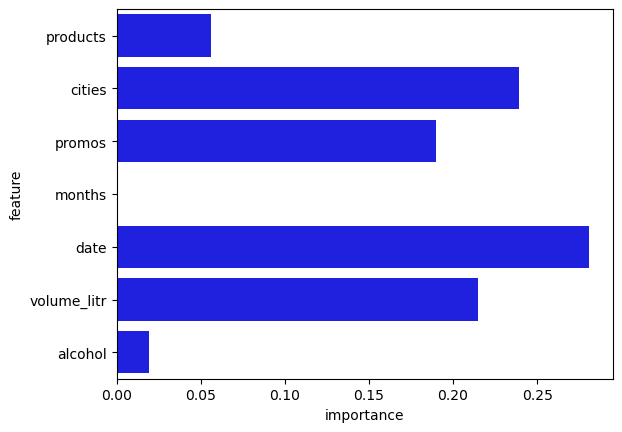

In [320]:
sns.barplot(data = feature_importances, y = 'feature', x = 'importance', orient = 'h', color='b')

### Градиентный бустинг

In [321]:
from sklearn.ensemble import GradientBoostingRegressor

In [322]:
param_grid_gbr = {'n_estimators':range(100,200,10), 'max_depth':range(4,6), 'min_samples_split':range(4,6)}

kfold  = KFold(n_splits = 5, shuffle = True, random_state = 42)

params = {'max_features':'sqrt',
          'criterion':'squared_error',
          'learning_rate':0.1,
          'min_samples_leaf':8,
          'verbose': True
          }

gbr = GradientBoostingRegressor(**params)

grid_search_rf = GridSearchCV(gbr, param_grid_gbr, verbose = 4, cv = kfold, scoring = 'r2', n_jobs = -1)

In [323]:
grid_result_gbr = grid_search_rf.fit(x_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
      Iter       Train Loss   Remaining Time 
         1         219.3339            5.09s
         2         217.2785            4.69s
         3         215.6456            4.66s
         4         213.3041            4.45s
         5         212.8955            4.29s
         6         209.9147            4.10s
         7         207.3721            4.07s
         8         203.6626            4.04s
         9         200.6845            4.04s
        10         199.5958            4.01s
        20         190.2183            3.62s
        30         182.3152            3.35s
        40         175.1159            3.13s
        50         171.0478            2.87s
        60         166.4575            2.64s
        70         163.9921            2.44s
        80         161.1693            2.24s
        90         158.9826            2.03s
       100         157.6755            1.82s


In [324]:
grid_result_gbr.best_score_

0.2410761022864289

In [325]:
grid_result_gbr.best_params_

{'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 190}

In [326]:
gbr = grid_result_gbr.best_estimator_

In [327]:
y_pred = gbr.predict(x_test)
print(r2_score(y_test,y_pred))

0.24145641546336327


In [328]:
y_pred = gbr.predict(x_train)
print(r2_score(y_train,y_pred))

0.36212480323381335


### XGBoost

In [329]:
import xgboost as xg

In [330]:
param_grid_xgb = {'max_features':['sqrt'],
                  'criterion':['mse'],
                  'learning_rate':[0.1], 
                  'n_estimators':range(100,300,10), 
                  'max_depth':range(2,4), 
                  'min_samples_split':range(4,6),
                  'verbose': [True]
                 }

kfold  = KFold(n_splits = 5, shuffle = True, random_state = 42)

xgb = xg.XGBRegressor()

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, verbose = 4, cv = kfold, scoring = 'r2', n_jobs = -1)

In [331]:
grid_result_xgb = grid_search_xgb.fit(x_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[13:09:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "criterion", "max_features", "min_samples_split", "verbose" } are not used.



In [332]:
grid_result_xgb.best_score_

0.2023688304642234

In [333]:
grid_result_xgb.best_params_

{'criterion': 'mse',
 'learning_rate': 0.1,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'n_estimators': 150,
 'verbose': True}

In [334]:
xgb = grid_result_xgb.best_estimator_

In [335]:
y_pred = xgb.predict(x_test)
y_pred_train = xgb.predict(x_train)
print(r2_score(y_test,y_pred))
print(r2_score(y_train,y_pred_train))

0.21689378899761314
0.33217125608310605


# Результаты

Наилучшую точность на тестовых данных показала модель на основании градиентного бустинга. Используя ее предскажем суммарный дополнительный объем, который принесла каждая акция за 2 года во всех городах

In [337]:
promo_result = pd.read_parquet('src/promo.parquet', engine='fastparquet')

In [338]:
PROMOS_NUMBER = len(promo_result)

In [339]:
promos_list = [i for i in range(0,PROMOS_NUMBER)]

effects_sum = 0

for promo in range(0,PROMOS_NUMBER):
    promo_df = x.copy()
    promo_df[[str(col) for col in promos_list[:promo]]]=0
    promo_df[[str(col) for col in promos_list[promo+1:]]]=0
    promo_df = promo_df[promo_df[str(promo)]!=0]
 
    if len(promo_df[promo_df[str(promo)]>0]) == 0:
        print(promo_result.iloc[promo]['Название'],' : ',0)
        continue
    
    #Нормализуем данные для расчета
    promo_df_norm = norm.transform(promo_df)
    promo_df = pd.DataFrame(promo_df_norm, columns = x.columns)


    effect_pred = gbr.predict(promo_df)
    effects_sum += effect_pred.sum()

    print(promo_result.iloc[promo]['Название'],' : ',effect_pred.sum())

Турнир трех волшебников за метлы  :  26215.32255802136
Клинок за пророк  :  25224.18377914579
Квоффл в кольцо  :  25615.98705279904
None  :  25324.837687612664
Конфетки за метки  :  26194.17713541895
Обмен любезностями  :  27157.715114540744
Лучше золотой снитч в руках, чем гиппогриф в небе  :  26177.066858349077
Сладкий бизнес при покупке от 15 литров в любом заведении  :  27411.515766905177
Двойная сладость  :  25647.890810844114
Минус 6 кнатов за безалкогольные напитки  :  0
(Орден Феникса)  :  0
(Орден Феникса)  :  34943.67635110209
Сладкий бизнес ноябрь 1997  :  25419.470834040556
Сладкий бизнес декабрь 1997  :  25299.478511302787
Сладкий бизнес и лягушка + 15 литров напитков  :  26202.697068670626
None  :  24363.65816522368
МетлаПлюс  :  27067.012360838686
Партнер заведений магазин Ханидьюкс 1997  :  36540.55223799705
Партнер заведений магазин Ханидьюкс  :  64621.69423079015
"Все и сразу" набор  :  27011.658139971398
Преданный фанат спорта  :  26620.795981848223
Магазин "Зонко" Д

# Все посчитали, все получилось